# Limpieza del conjunto de datos *Colonias-INEGI*

En esta *notebook* se documenta el proceso de **limpieza** del conjunto de datos **Colonias-INEGI**, correspondiente a las delimitaciones geoestadísticas de colonias del municipio de **Hermosillo, Sonora**, obtenidas desde el portal del **Instituto Nacional de Estadística y Geografía (INEGI)**.

El propósito es **filtrar, estandarizar y preparar** la información geoespacial de las colonias urbanas, asegurando su compatibilidad con otras fuentes de datos municipales (como *vialidades*, *atus* y *clima*), con el fin de obtener un conjunto *tidy* listo para análisis y visualización.

Los datos provienen del producto oficial **“Colonias — Delimitaciones Geoestadísticas”** publicado por INEGI, y fueron descargados directamente mediante el siguiente *script*:

```bash
python src/download_colonias.py
```

Posteriormente, los archivos ZIP fueron **extraídos** con:

```bash
python src/extract_colonias.py
```

Este flujo genera los archivos *raw* en formato **Shapefile**, almacenados en la carpeta [`data/raw/colonias`](../data/raw/colonias/).

## 0. Configuración del entorno

Importamos las librerías princpipales: 

In [1]:
import os
from pathlib import Path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import missingno as msno

Definimos un ruta a un directorio temporal para almacenar datos en caso de ser necesario: 

In [2]:
temp_dir = Path().resolve().parent / "data" / "temp" / "colonias"
temp_dir.mkdir(parents=True, exist_ok=True)

Definimos las rutas de acceso a los datos *raw* del conjunto Colinias-INEGI: 

In [3]:
root = Path().resolve().parent
data_dir = root / "data"
raw_dir = data_dir / "raw"
colonias_dir = raw_dir / "colonias"

for item in colonias_dir.iterdir(): 
    print(item.relative_to(root))

data\raw\colonias\794551132180_s
data\raw\colonias\794551132180_s.zip


En el directorio `data/raw/vialidades` se encuentra:

* `794551132180_s.zip`: Archivo ZIP de los datos

* `794551132180_s`: Directorio con los datos extraidos de `794551132180_s.zip`

El directorio `794551132180_s` posee el siguiente contenido: 

In [4]:
for item in colonias_dir.rglob("*"):
    print(item.relative_to(item.parent))

794551132180_s
794551132180_s.zip
catalogos
conjunto_de_datos
metadatos
asentamientos_humanos.csv
asentamientos_humanos.pdf
contenido.pdf
contenido.txt
00as.CPG
00as.dbf
00as.prj
00as.sbn
00as.sbx
00as.shp
00as.shx
delimitacion_de_colonias_y_otros_asentamientos_humanos_2024_integrado.txt
delimitacion_de_colonias_y_otros_asentamientos_humanos_2024_integrado.xml
metadatos_dcah_2024_integrado.txt


Los datos georeferenciados están se encuentran en el archivo `794551132180_s/conjunto_de_datos/00as.shp`

In [5]:
colonias_shp = colonias_dir / "794551132180_s" / "conjunto_de_datos" / "00as.shp"

# Verificamos que el archivo existe y puede cargarse en memoria: 
colonias_shp.exists(), colonias_shp.is_file()

(True, True)

### 0.1 Algunas funciones auxiliares


A continuación se definen algunas funciones auxiliares útiles para explorar el conjunto de datos: 

In [6]:
def add_basemap_to_ax(ax, crs):
    ctx.add_basemap(
        ax, 
        source=ctx.providers.OpenStreetMap.Mapnik, 
        crs=crs.to_string()
    )

## 1. Carga y descripción general

Cargamos los datos de las colonias usando *GeoPandas*: 

In [7]:
colonias = gpd.read_file(colonias_shp)

Los primeros registros: 

In [8]:
colonias.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_ASEN,CP,FECHA_ACT,INSTITUCIO,NOM_ASEN,TIPO,Shape_Leng,Shape_Area,geometry
0,0100100010001,01,001,0001,0001,20263,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,AGUA CLARA,FRACCIONAMIENTO,1107.383585,52767.800484,"POLYGON ((2474021.992 1093915.819, 2474034.109..."
1,0100100010002,01,001,0001,0002,20159,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,ALIANZA FERROCARRILERA,FRACCIONAMIENTO,1938.265565,97261.356447,"POLYGON ((2471105.967 1099065.062, 2471107.515..."
2,0100100010003,01,001,0001,0003,20040,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,ALTAVISTA,COLONIA,2569.108212,368212.263364,"POLYGON ((2468095.184 1097647.988, 2468169.06 ..."
3,0100100010004,01,001,0001,0004,20230,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,LAS AMERICAS,FRACCIONAMIENTO,3548.120214,462805.496892,"POLYGON ((2469185.751 1094893.007, 2469280.792..."
4,0100100010005,01,001,0001,0005,20020,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,LAS ARBOLEDAS,FRACCIONAMIENTO,2418.992126,201564.185798,"POLYGON ((2468943.182 1098316.269, 2468946.723..."


Información general: 

In [9]:
colonias.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75516 entries, 0 to 75515
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CVEGEO      75516 non-null  object  
 1   CVE_ENT     75516 non-null  object  
 2   CVE_MUN     75516 non-null  object  
 3   CVE_LOC     75516 non-null  object  
 4   CVE_ASEN    75516 non-null  object  
 5   CP          75516 non-null  object  
 6   FECHA_ACT   75516 non-null  object  
 7   INSTITUCIO  75516 non-null  object  
 8   NOM_ASEN    75516 non-null  object  
 9   TIPO        75516 non-null  object  
 10  Shape_Leng  75516 non-null  float64 
 11  Shape_Area  75516 non-null  float64 
 12  geometry    75516 non-null  geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 7.5+ MB


Parece que no existen datos nulos en el archivo, verifiquemos esto usando *missingno*: 

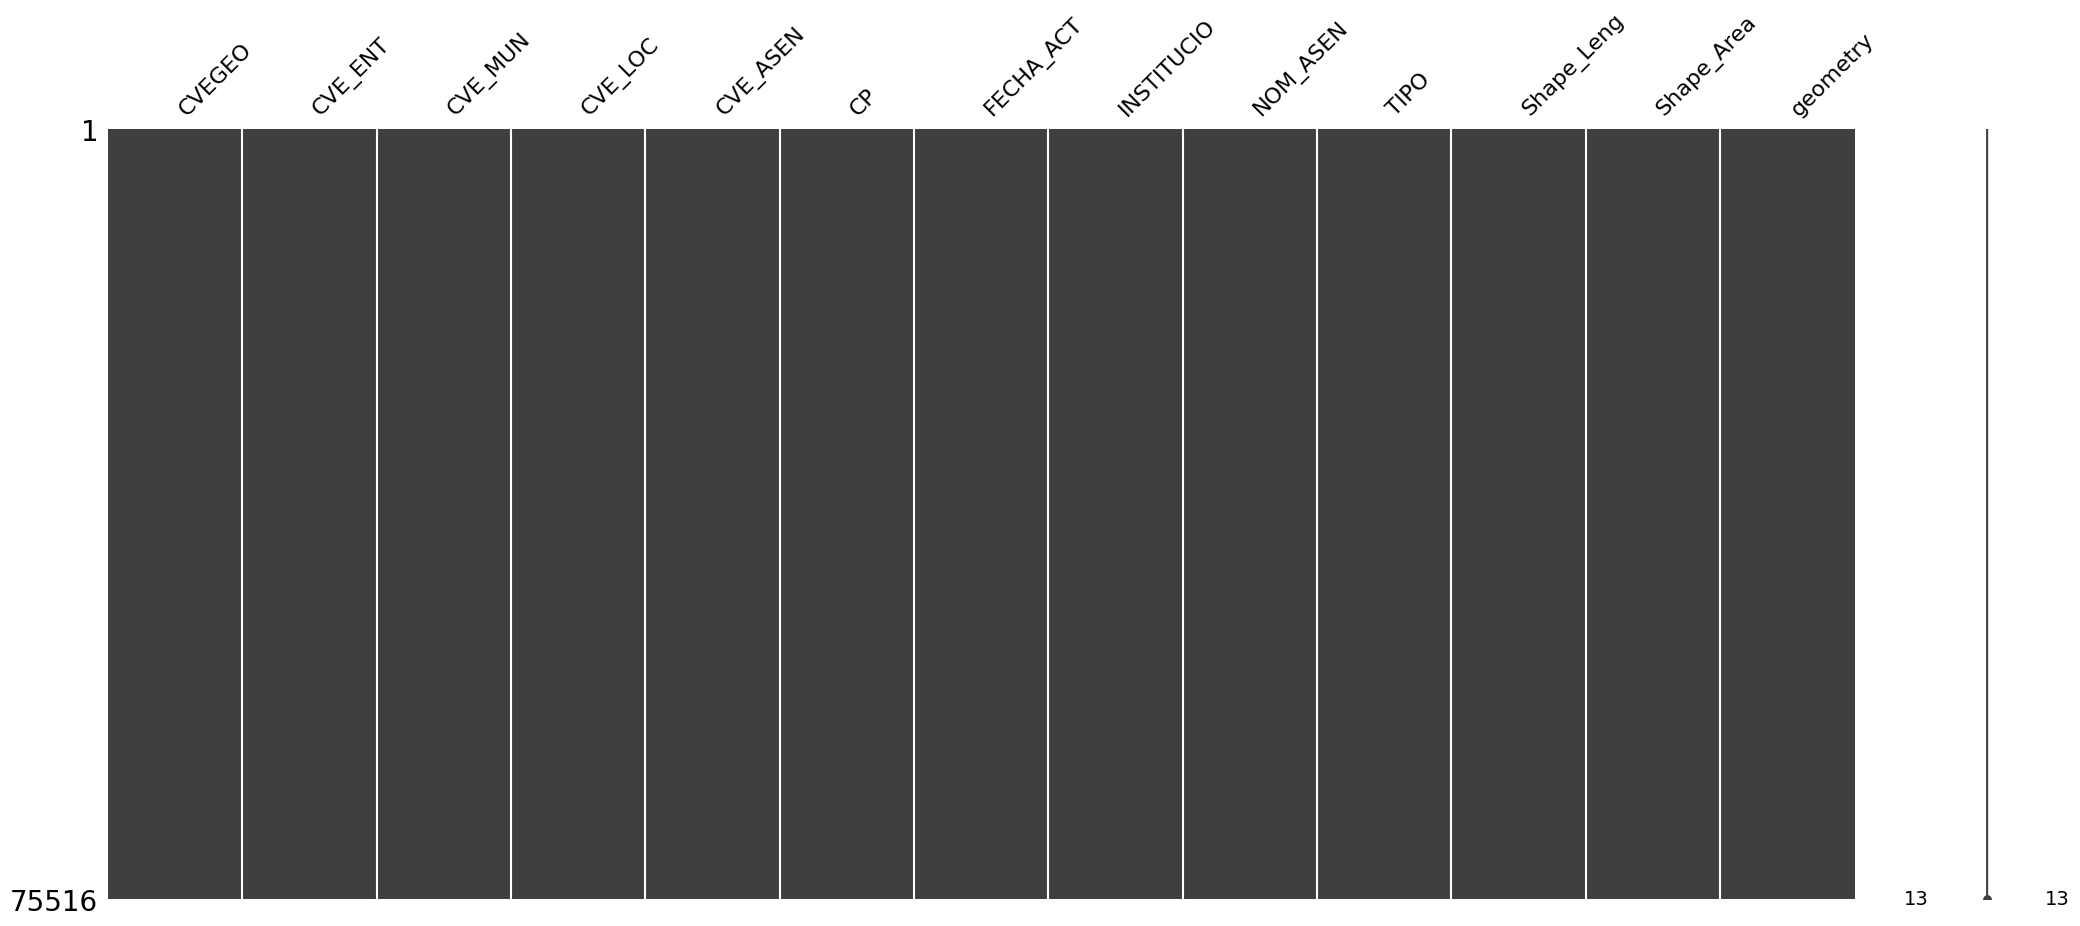

In [10]:
msno.matrix(colonias)
plt.show()

Efectivamente, no existen datos nulos. 

Los tipos de geometrías únicos: 

In [11]:
colonias.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

El *csr* (*coordinate reference system*): 

In [76]:
colonias.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

El *crs* que contiene el conjunto de datos es no estándar. 

Según la [documentación](../data/raw/colonias/794551132180_s/catalogos/contenido.pdf) del conjunto de datos, se utiliza un sistema de referencia basado en el marco geodésico *ITRF2008 /LCC Mexico*, con una proyección **Lambert Conformal Conic** adaptada a México. Además, se menciona que las unidades de área y perímetro se encuentran en metros. 

Para operar con los demás conjuntos de datos geoespaciales (como Vialidades-OSM) será necesario mantener un *crs* fijo, por conveniencia reproyectaremos los datos a **WGS84 (`EPGS=4326`)**, que es el estándar internacinal usando por la mayoria de aplicaciones web y sistemas GIS.

Reproyectamos los datos al sistema de coordenadas geográficas WGS84: 

In [13]:
colonias = colonias.to_crs(epsg=4326, )

Ahora podemos trabajar con coordenadas (latitud, longitud), lo que permite visualizar los datos con herramientas basadas en mapas web (como Leaflet): 

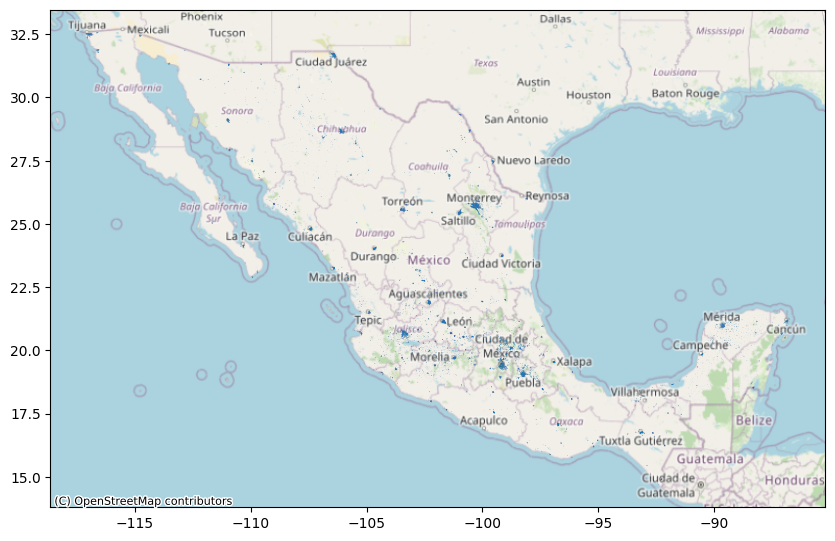

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

colonias.plot(ax=ax)
add_basemap_to_ax(ax, colonias.crs)

Observamos que el conjunto de datos corresponde a las colonias de todo el pais, por lo que será necesario filtrar aquellas que se encuentran en Hermosillo, Sonora. 

## 2. Exploración y limpieza del conjunto de datos

Las columnas: 

In [15]:
columns = colonias.columns.tolist()
columns

['CVEGEO',
 'CVE_ENT',
 'CVE_MUN',
 'CVE_LOC',
 'CVE_ASEN',
 'CP',
 'FECHA_ACT',
 'INSTITUCIO',
 'NOM_ASEN',
 'TIPO',
 'Shape_Leng',
 'Shape_Area',
 'geometry']

Conviene trabajar con los nombres de las columnas normalizados:

In [16]:
colonias.columns = colonias.columns.str.lower()

In [17]:
colonias.columns

Index(['cvegeo', 'cve_ent', 'cve_mun', 'cve_loc', 'cve_asen', 'cp',
       'fecha_act', 'institucio', 'nom_asen', 'tipo', 'shape_leng',
       'shape_area', 'geometry'],
      dtype='object')

Las columnas `cve_ent` y `cve_mun`

In [18]:
colonias[['cve_ent', 'cve_mun']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75516 entries, 0 to 75515
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cve_ent  75516 non-null  object
 1   cve_mun  75516 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [19]:
colonias[['cve_ent', 'cve_mun']].describe()

,cve_ent,cve_mun
count,75516,75516
unique,32,185
top,14,006
freq,7928,2569


Las claves de las entidades de México:

In [20]:
colonias['cve_ent'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

Las claves de los municipios en México: 

In [21]:
colonias['cve_mun'].unique()

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '051', '061', '065', '078', '079', '086', '089',
       '101', '106', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '052', '053', '054', '055',
       '056', '057', '058', '059', '060', '062', '063', '064', '066',
       '067', '072', '075', '068', '069', '070', '071', '073', '074',
       '076', '077', '080', '081', '082', '083', '084', '085', '087',
       '088', '090', '091', '092', '093', '094', '095', '096', '097',
       '098', '099', '100', '102', '103', '104', '105', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '124', '125', '131',
       '133', '143',

Las claves de las localidades en México: 

In [22]:
colonias['cve_loc'].unique()

array(['0001', '0106', '0125', ..., '0538', '0735', '1289'],
      shape=(1003,), dtype=object)

Iniciamos por filtrar los datos que corresponden a la **zona urbana de Hermosillo**. 

Según el [diccionario de datos](../data/raw/colonias/794551132180_s/catalogos/asentamientos_humanos.csv), Sonora posee la clave de entidad 26 (`cve_ent=26`) y Hermosillo la clave de municipio 30 (`cve_mub=30`). 

In [23]:
colonias[['cve_ent', 'cve_mun', 'cve_loc']] = colonias[['cve_ent', 'cve_mun', 'cve_loc']].astype(int)

In [34]:
colonias_hmo = colonias[(colonias['cve_ent'] == 26) & (colonias['cve_mun'] == 30)]

Según el [diccionario de datos](../data/raw/colonias/794551132180_s/catalogos/asentamientos_humanos.csv), la **zona urbana de Hermosillo** posee clave de localidad conn valor 1 (`cve_loc=1`): 

In [38]:
colonias_hmo_urb = colonias_hmo[colonias_hmo['cve_loc'] == 1]

Visualizamos las colonias de Hermosillo: 

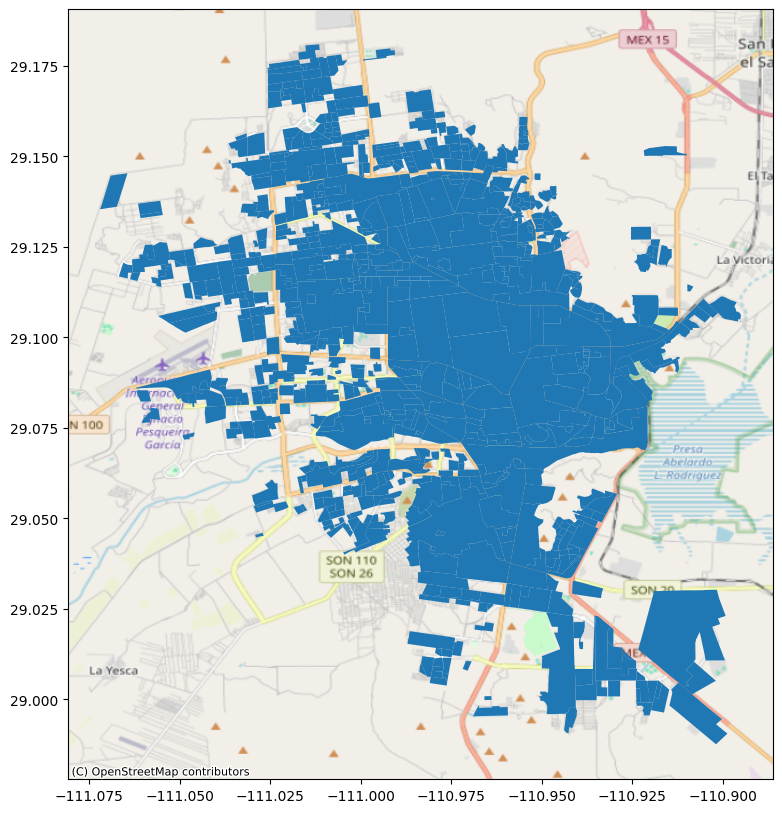

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))

colonias_hmo_urb.plot(
    ax=ax, 
    aspect='equal'
    )
add_basemap_to_ax(ax, colonias_hmo_urb.crs)
plt.show()

Eliminamos las columnas {`cve_end`, `cve_mun`, `cve_loc`}: 

In [43]:

colonias_hmo_urb.drop(columns=['cve_loc', 'cve_ent', 'cve_mun'], inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_21016\2125121388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colonias_hmo_urb.drop(columns=['cve_loc', 'cve_ent', 'cve_mun'], inplace=True)


Guardamos los datos en el directorio temporal: 

In [44]:
colonias_hmo_urb.to_file(temp_dir.joinpath("colonias_hmo_urb.geojson"), driver='GeoJSON')

In [48]:
colonias_hmo_urb.columns.tolist()

['cvegeo',
 'cve_asen',
 'cp',
 'fecha_act',
 'institucio',
 'nom_asen',
 'tipo',
 'shape_leng',
 'shape_area',
 'geometry']

La columna `cvegeo` asigna a cada registro una clave única: 

In [49]:
colonias_hmo_urb['cvegeo']

66032    2603000010001
66033    2603000010002
66034    2603000010003
66035    2603000010004
66036    2603000010005
             ...      
66771    2603000010933
66772    2603000010934
66773    2603000010935
66774    2603000010936
66775    2603000010937
Name: cvegeo, Length: 744, dtype: object

La columna `cve_asen` posee la clave del asentamiento urbano para cada registro: 

In [51]:
colonias_hmo_urb['cve_asen'].describe()

count      744
unique     744
top       0001
freq         1
Name: cve_asen, dtype: object

Los nombres de los asentamientos: 

In [55]:
colonias_hmo_urb['nom_asen'].head()

66032               y griega
66033       22 de septiembre
66034              5 de mayo
66035    adolfo de la huerta
66036    adolfo lópez mateos
Name: nom_asen, dtype: object

El total de colonias con nombres únicos: 

In [56]:
len(colonias_hmo_urb['nom_asen'].unique())

724

In [52]:
colonias_hmo_urb['nom_asen'].value_counts()[:10]

nom_asen
PARQUE INDUSTRIAL     3
VILLA COLONIAL        3
CASA BLANCA           2
LAS LOMAS             2
REAL DE MINAS         2
PRIMERO HERMOSILLO    2
ALTARES               2
QUINTA EMILIA         2
VIRREYES              2
SAN PABLO             2
Name: count, dtype: int64

Normalizamos la columna `nom_asen`: 

In [57]:
colonias_hmo_urb['nom_asen'] = colonias_hmo_urb['nom_asen'].str.lower()

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


El tipo de asentamiento:  

In [59]:
colonias_hmo_urb['tipo'].head()

66032     BARRIO
66033    COLONIA
66034    COLONIA
66035    COLONIA
66036    COLONIA
Name: tipo, dtype: object

Los tipos de asentamiento únicos: 

In [60]:
colonias_hmo_urb['tipo'].unique()

array(['BARRIO', 'COLONIA', 'FRACCIONAMIENTO', 'PRIVADA', 'RESIDENCIAL',
       'PARQUE INDUSTRIAL', 'SECTOR', 'ZONA MILITAR', 'NINGUNO',
       'AMPLIACIÓN', 'CONDOMINIO', 'ZONA INDUSTRIAL'], dtype=object)

In [62]:
colonias_hmo_urb['tipo'].value_counts()

tipo
FRACCIONAMIENTO      378
COLONIA              278
RESIDENCIAL           33
PRIVADA               19
PARQUE INDUSTRIAL     11
AMPLIACIÓN             7
SECTOR                 5
CONDOMINIO             4
NINGUNO                4
BARRIO                 3
ZONA MILITAR           1
ZONA INDUSTRIAL        1
Name: count, dtype: int64

Normalizamos la columna `tipo`: 

In [63]:
colonias_hmo_urb['tipo'] = colonias_hmo_urb['tipo'].str.lower()

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


La columna `shape_leng` reprecenta el perímetro del poligono metros: 

In [64]:
colonias_hmo_urb['shape_leng'].describe()

count      744.000000
mean      1707.454030
std       1423.905905
min        112.573283
25%        883.121786
50%       1314.930843
75%       2030.789472
max      14497.483459
Name: shape_leng, dtype: float64

La columna `shape_area` reprecenta el área del poligono en metros cuadrados: 

In [65]:
colonias_hmo_urb['shape_area'].describe()

count    7.440000e+02
mean     1.742039e+05
std      3.337669e+05
min      8.985956e+02
25%      3.885688e+04
50%      8.251834e+04
75%      1.704152e+05
max      4.546265e+06
Name: shape_area, dtype: float64

In [67]:
colonias_hmo_urb.rename(
    columns={
        'shape_leng': 'perimetro_m', 
        'shape_area': 'area_m2'
    }, 
    inplace=True
)

C:\Users\isaul\AppData\Local\Temp\ipykernel_21016\2880305265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colonias_hmo_urb.rename(


In [69]:
colonias_hmo_urb['fecha_act'].unique()

array(['11/2021'], dtype=object)

In [70]:
colonias_hmo_urb['institucio'].unique()

array(['DIRECCIÓN DE CATASTRO, HERMOSILLO'], dtype=object)

Las columnas `institucio` (institución que realizó el censo), `fecha_act` (fecha en la que se realizó el censo) no son de utilidad para los fines del proyecto. Podemos eliminarlas:  

In [72]:
colonias_hmo_urb.drop(columns=['institucio', 'fecha_act'], inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_21016\2422087838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colonias_hmo_urb.drop(columns=['institucio', 'fecha_act'], inplace=True)


Guardamos los datos limpios en el directorio temporal: 

In [73]:
colonias_hmo_urb.to_file(temp_dir.joinpath('colonias_hmo_urb_clean.geojson'), driver='GeoJSON')

## 3. Conclusiones 

El conunto de datos limpio posee la siguiente estructura: 

In [74]:
colonias_hmo_urb.head()

,cvegeo,cve_asen,cp,nom_asen,tipo,perimetro_m,area_m2,geometry
66032,2603000010001,0001,83290,y griega,barrio,3242.570807,588003.672042,"POLYGON ((-110.95867 29.03755, -110.95854 29.0..."
66033,2603000010002,0002,83170,22 de septiembre,colonia,1490.542076,91522.382755,"POLYGON ((-111.0004 29.10823, -111.00038 29.10..."
66034,2603000010003,0003,83010,5 de mayo,colonia,2741.592650,412142.736606,"POLYGON ((-110.94174 29.08998, -110.94183 29.0..."
66035,2603000010004,0004,83295,adolfo de la huerta,colonia,1894.537972,170764.281316,"POLYGON ((-110.95891 29.0255, -110.95879 29.02..."
66036,2603000010005,0005,83170,adolfo lópez mateos,colonia,4004.081803,664894.362011,"POLYGON ((-110.9946 29.11446, -110.99459 29.11..."


Se han conservado únicamente los asentamientos urbanos correspondientes a la zona urbana de Hermosillo y los atributos necesarios para el análsis de los accidentes y su relación con los baches. 

De las **13 columnas iniciales**, se seleccionaron 7 variables que contienen la información reelevante para el posterior análisis. 

El proceso de limpieza descrito en esta libreta ha sido **automatizado** en el *script* [`src/clean_colonias.py`](../src/clean_colonias.py), asegurando reproducibilidad e integración al *pipeline* del proyecto. 